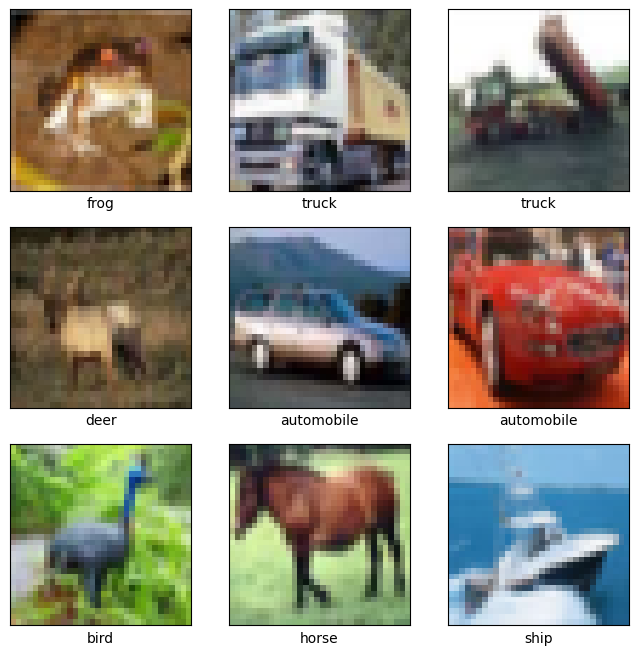

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Define class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

# Visualize the first 9 images
plt.figure(figsize=(8,8))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(class_names[int(y_train[i].item())])
plt.show()

In [24]:
# Import libraries
import torch
import torchvision.transforms as transforms
from torchvision import models

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])# Define transforms: resize, convert to tensor, normalize


# Example: transform a single image
img = x_train[0]  # numpy array
img_tensor = transform(img)  # shape: (3, 224, 224)

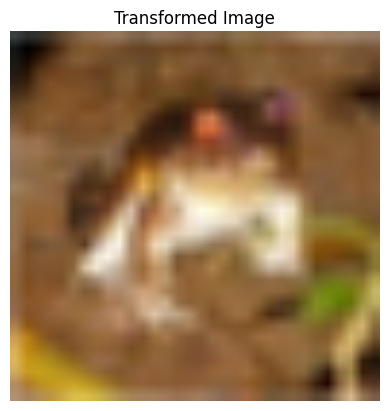

In [25]:
# Show a transformed image (after resizing and normalization)
import torchvision.transforms.functional as F

def unnormalize(img_tensor):
    device = img_tensor.device
    if img_tensor.dim() == 4:
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(1, 3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(1, 3, 1, 1)
    else:
        mean = torch.tensor([0.485, 0.456, 0.406], device=device).view(3, 1, 1)
        std = torch.tensor([0.229, 0.224, 0.225], device=device).view(3, 1, 1)
    return img_tensor * std + mean

# Transform and show the image
img = x_train[0]
img_tensor = transform(img)
img_unnorm = unnormalize(img_tensor)

# Convert to numpy for matplotlib (C, H, W) -> (H, W, C)
img_np = img_unnorm.permute(1, 2, 0).numpy()
img_np = np.clip(img_np, 0, 1)

plt.imshow(img_np)
plt.title("Transformed Image")
plt.axis('off')
plt.show()

In [26]:
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

class CIFAR10TorchDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = int(self.labels[idx].item())  # Fix: use .item() to get scalar
        if self.transform:
            img = self.transform(img)
        return img, label

# Flatten y_train for stratification
y_train_flat = y_train.flatten()

# Split train into train/val (80/20) with stratification
x_train_split, x_val, y_train_split, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42, stratify=y_train_flat
)

# Create PyTorch datasets for train and validation
train_dataset = CIFAR10TorchDataset(x_train_split, y_train_split, transform=transform)
val_dataset = CIFAR10TorchDataset(x_val, y_val, transform=transform)
test_dataset = CIFAR10TorchDataset(x_test, y_test, transform=transform)
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [27]:
import torch.nn as nn
from torchvision.models import GoogLeNet_Weights

def get_googlenet(pretrained=True):
    if pretrained:
        model = models.googlenet(weights=GoogLeNet_Weights.IMAGENET1K_V1)
    else:
        model = models.googlenet(weights=None, init_weights=True)  # Explicit init
    model.fc = nn.Linear(model.fc.in_features, 10)
    return model

In [28]:
print(torch.cuda.is_available())  # Should be True
print(torch.cuda.device_count())  # Should be > 0
print(torch.cuda.get_device_name(0))  # Should return GPU name
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True
1
NVIDIA GeForce RTX 4090


In [29]:
# Teacher model (pretrained weights)
teacher_model = get_googlenet(pretrained=True)

model_path = "best_model_googleLenet.pth"
teacher_model.to(device)
teacher_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
teacher_model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = teacher_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 93.89%


In [30]:
# Student model
student_model = get_googlenet(pretrained=False)

In [31]:
import torch.nn.functional as F

#Temperature-scaled softmax cross-entropy loss for distillation
def distillation_loss(student_logits, teacher_logits, labels, T, alpha):
    """
    student_logits: output of student model (before softmax)
    teacher_logits: output of teacher model (before softmax)
    labels: ground truth labels
    T: temperature
    alpha: weight between distillation loss and true label loss
    """
    # Soft targets
    soft_targets = F.softmax(teacher_logits / T, dim=1)
    student_soft = F.log_softmax(student_logits / T, dim=1)
    distill_loss = F.kl_div(student_soft, soft_targets, reduction='batchmean') * (T * T)
    # Hard targets
    ce_loss = F.cross_entropy(student_logits, labels)
    return alpha * distill_loss + (1 - alpha) * ce_loss

In [32]:
def train_distillation(student_model, teacher_model, train_loader, val_loader, device, epochs=20, lr=1e-3, T=20, alpha=0.7, patience=5, save_path="best_student_distilled.pth"):
    """
    Trains a student model using defensive distillation.
    Args:
        student_model: The student PyTorch model to train.
        teacher_model: The pre-trained teacher PyTorch model (should be in eval mode, weights frozen).
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        device: torch.device.
        epochs: Number of epochs.
        lr: Learning rate.
        T: Temperature for distillation.
        alpha: Weight for distillation loss.
        patience: Early stopping patience.
        save_path: Where to save the best student model.
    """
    import torch
    import torch.nn.functional as F
    import torch.optim as optim
    from tqdm import tqdm

    # Make sure teacher is in eval mode and frozen
    teacher_model.eval()
    for param in teacher_model.parameters():
        param.requires_grad = False

    student_model.to(device)
    teacher_model.to(device)
    optimizer = optim.Adam(student_model.parameters(), lr=lr)

    best_val_acc = 0.0
    patience_counter = 0

    for epoch in range(epochs):
        student_model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Distill Train]", leave=False)
        for images, labels in loop:
            images = images.to(device)
            labels = labels.to(device).squeeze()

            # Forward pass through teacher (no grad)
            with torch.no_grad():
                teacher_logits = teacher_model(images)
                if isinstance(teacher_logits, tuple) or hasattr(teacher_logits, 'logits'):
                    teacher_logits = teacher_logits.logits if hasattr(teacher_logits, 'logits') else teacher_logits[0]

            # Forward pass through student
            student_logits = student_model(images)
            if isinstance(student_logits, tuple) or hasattr(student_logits, 'logits'):
                student_logits = student_logits.logits if hasattr(student_logits, 'logits') else student_logits[0]

            # Compute distillation loss
            loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = student_logits.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
            loop.set_postfix(loss=loss.item())
        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        student_model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        loop_val = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]", leave=False)
        with torch.no_grad():
            for images, labels in loop_val:
                images = images.to(device)
                labels = labels.to(device).squeeze()
                teacher_logits = teacher_model(images)
                student_logits = student_model(images)
                loss = distillation_loss(student_logits, teacher_logits, labels, T, alpha)
                val_loss += loss.item() * images.size(0)
                _, predicted = student_logits.max(1)
                val_correct += predicted.eq(labels).sum().item()
                val_total += labels.size(0)
                loop_val.set_postfix(loss=loss.item())
        val_loss /= val_total
        val_acc = val_correct / val_total

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Distill Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Early stopping based on validation accuracy (higher is better)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(student_model.state_dict(), save_path)
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                student_model.load_state_dict(torch.load(save_path))
                break

    print(f"Best validation accuracy: {best_val_acc:.4f}")
    return student_model

In [33]:
T = 20           # Temperature (as in Papernot et al.)
alpha = 0.7      # Weight for distillation loss
epochs = 50      # Number of epochs
lr = 1e-4        # Learning rate

# Train the student with distillation
student_model = train_distillation(
    student_model,
    teacher_model,
    train_loader,
    val_loader,
    device,
    epochs=epochs,
    lr=lr,
    T=T,
    alpha=alpha,
    patience=5,
    save_path="best_student_distilled.pth"
)

Epoch 1/50 | Distill Train Loss: 1.9250, Train Acc: 0.5501 | Val Loss: 1.3675, Val Acc: 0.6675


Epoch 2/50 | Distill Train Loss: 1.1498, Train Acc: 0.7369 | Val Loss: 1.0235, Val Acc: 0.7583


Epoch 3/50 | Distill Train Loss: 0.8130, Train Acc: 0.8138 | Val Loss: 0.8509, Val Acc: 0.7949


Epoch 4/50 | Distill Train Loss: 0.6363, Train Acc: 0.8599 | Val Loss: 0.7409, Val Acc: 0.8141


Epoch 5/50 | Distill Train Loss: 0.5080, Train Acc: 0.8925 | Val Loss: 0.7331, Val Acc: 0.8205


Epoch 6/50 | Distill Train Loss: 0.4235, Train Acc: 0.9152 | Val Loss: 0.5637, Val Acc: 0.8501


Epoch 7/50 | Distill Train Loss: 0.3506, Train Acc: 0.9362 | Val Loss: 0.5458, Val Acc: 0.8614


Epoch 8/50 | Distill Train Loss: 0.2904, Train Acc: 0.9543 | Val Loss: 0.5595, Val Acc: 0.8549


Epoch 9/50 | Distill Train Loss: 0.2553, Train Acc: 0.9663 | Val Loss: 0.5600, Val Acc: 0.8648


Epoch 10/50 | Distill Train Loss: 0.2320, Train Acc: 0.9719 | Val Loss: 0.4703, Val Acc: 0.8769


Epoch 11/50 | Distill Train Loss: 0.2164, Train Acc: 0.9761 | Val Loss: 0.5937, Val Acc: 0.8537


Epoch 12/50 | Distill Train Loss: 0.1933, Train Acc: 0.9814 | Val Loss: 0.4257, Val Acc: 0.8865


Epoch 13/50 | Distill Train Loss: 0.1933, Train Acc: 0.9827 | Val Loss: 0.4980, Val Acc: 0.8713


Epoch 14/50 | Distill Train Loss: 0.1775, Train Acc: 0.9859 | Val Loss: 0.4006, Val Acc: 0.8942


Epoch 15/50 | Distill Train Loss: 0.1743, Train Acc: 0.9864 | Val Loss: 0.4526, Val Acc: 0.8831


Epoch 16/50 | Distill Train Loss: 0.1673, Train Acc: 0.9875 | Val Loss: 0.5075, Val Acc: 0.8736


Epoch 17/50 | Distill Train Loss: 0.1681, Train Acc: 0.9861 | Val Loss: 0.4418, Val Acc: 0.8824


Epoch 18/50 | Distill Train Loss: 0.1660, Train Acc: 0.9867 | Val Loss: 0.4309, Val Acc: 0.8860


Epoch 19/50 | Distill Train Loss: 0.1616, Train Acc: 0.9876 | Val Loss: 0.4098, Val Acc: 0.8893
Early stopping at epoch 19
Best validation accuracy: 0.8942


C:\Users\manua\AppData\Local\Temp\ipykernel_18972\4047546711.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  student_model.load_state_dict(torch.load(save_path))


In [36]:
model_path = "best_student_distilled.pth"
student_model = get_googlenet(pretrained=False)
student_model.to(device)
student_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
student_model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = student_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 89.17%


In [37]:
import foolbox as fb

student_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
student_model.eval()
# Preparazione dei dati vper foolbox
transform_fgsm = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_dataset_attack = CIFAR10TorchDataset(x_test, y_test, transform=transform_fgsm)

test_loader_attack = DataLoader(test_dataset_attack, batch_size=128, shuffle=False)

In [38]:
def convert_normalization(imgs):
    """
    Convert a batch of images from normalization (mean=0.5, std=0.5)
    to GoogLeNet normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]).
    imgs: torch.Tensor of shape (B, 3, H, W)
    Returns: torch.Tensor of same shape, normalized for GoogLeNet
    """
    # Unnormalize from (0.5, 0.5, 0.5) to [0, 1]
    imgs = imgs * 0.5 + 0.5
    # Normalize to GoogLeNet
    mean = torch.tensor([0.485, 0.456, 0.406], device=imgs.device).view(1, 3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225], device=imgs.device).view(1, 3, 1, 1)
    imgs = (imgs - mean) / std
    return imgs

In [39]:
import random
# Prendi un batch di esempi per il test
images, labels = next(iter(test_loader_attack))
images, labels = images.to(device), labels.to(device)

# Converti il modello per Foolbox
fmodel = fb.PyTorchModel(student_model, bounds=(-1, 1))  # CIFAR-10 normalizzato tra -1 e 1

# 1. Attacco FGSM (Fast Gradient Sign Method)
print("\nRunning FGSM Attack...")
attack_fgsm = fb.attacks.FGSM()
epsilons = [0.05, 0.1, 0.2]
advs_fgsm_list = []
advs_pgd_list = []
fgsm_acc_list = []
pgd_acc_list = []

for eps in epsilons:
    print(f"Running attacks with epsilon={eps}...")
    advs_fgsm, _, _ = attack_fgsm(fmodel, images, labels, epsilons=eps)
    # 2. Attacco PGD (Projected Gradient Descent)
    attack_pgd = fb.attacks.LinfPGD(steps=10, rel_stepsize=0.1)
    advs_pgd, _, _ = attack_pgd(fmodel, images, labels, epsilons=eps)

    advs_fgsm_norm = convert_normalization(advs_fgsm)
    advs_pgd_norm = convert_normalization(advs_pgd)

    fgsm_acc = 100 * (student_model(advs_fgsm_norm).argmax(axis=1) == labels).float().mean().item()
    pgd_acc = 100 * (student_model(advs_pgd_norm).argmax(axis=1) == labels).float().mean().item()

    print(f"Accuracy under FGSM (eps={eps}): {fgsm_acc:.2f}%")
    print(f"Accuracy under PGD (eps={eps}): {pgd_acc:.2f}%")
    print(("\n\n"))

    advs_fgsm_list.append(advs_fgsm_norm)
    advs_pgd_list.append(advs_pgd_norm)
    fgsm_acc_list.append(fgsm_acc)
    pgd_acc_list.append(pgd_acc)

# Mostra un esempio casuale per ogni epsilon
class_names = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
for i, eps in enumerate(epsilons):
    rand_idx = random.randint(0, images.shape[0] - 1)
    clean_pred = class_names[student_model(images[rand_idx:rand_idx+1]).argmax().item()]
    adv_pred_fgsm = class_names[student_model(advs_fgsm_list[i][rand_idx:rand_idx+1]).argmax().item()]
    adv_pred_pgd = class_names[student_model(advs_pgd_list[i][rand_idx:rand_idx+1]).argmax().item()]
    label_name = class_names[labels[rand_idx].item()]


Running FGSM Attack...
Running attacks with epsilon=0.05...
Accuracy under FGSM (eps=0.05): 17.19%
Accuracy under PGD (eps=0.05): 10.94%



Running attacks with epsilon=0.1...
Accuracy under FGSM (eps=0.1): 14.06%
Accuracy under PGD (eps=0.1): 6.25%



Running attacks with epsilon=0.2...
Accuracy under FGSM (eps=0.2): 15.62%
Accuracy under PGD (eps=0.2): 0.78%





In [41]:
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as psnr

def run_attacks_metrics(model, test_loader, device, epsilons=[0.01, 0.03, 0.05]):
    import foolbox as fb

    model.eval()
    fmodel = fb.PyTorchModel(model, bounds=(-1, 1))
    class_names = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    results = []

    # For aggregate confusion
    fgsm_agg_conf = np.zeros((10, 10), dtype=int)
    pgd_agg_conf = np.zeros((10, 10), dtype=int)

    # Collect all test images and labels
    all_images = []
    all_labels = []
    for images, labels in test_loader:
        all_images.append(images)
        all_labels.append(labels)
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    total_images = all_images.shape[0]

    fgsm_conf_matrices = []
    pgd_conf_matrices = []

    # PSNR metrics
    fgsm_psnr_per_eps = {}
    fgsm_psnr_per_class = {}
    pgd_psnr_per_eps = {}
    pgd_psnr_per_class = {}

    for eps in epsilons:
        batch_size = 128
        clean_correct = 0
        fgsm_correct = 0
        pgd_correct = 0
        total = 0

        fgsm_confusion = np.zeros((10, 10), dtype=int)
        pgd_confusion = np.zeros((10, 10), dtype=int)

        # For PSNR
        fgsm_psnr_list = []
        fgsm_psnr_per_class_list = [[] for _ in range(10)]
        pgd_psnr_list = []
        pgd_psnr_per_class_list = [[] for _ in range(10)]

        for i in range(0, total_images, batch_size):
            batch_imgs = all_images[i:i+batch_size].to(device)
            batch_lbls = all_labels[i:i+batch_size].to(device)

            attack_fgsm = fb.attacks.FGSM()
            advs_fgsm, _, _ = attack_fgsm(fmodel, batch_imgs, batch_lbls, epsilons=eps)
            attack_pgd = fb.attacks.LinfPGD(steps=10, rel_stepsize=0.1)
            advs_pgd, _, _ = attack_pgd(fmodel, batch_imgs, batch_lbls, epsilons=eps)

            batch_imgs_norm = convert_normalization(batch_imgs)  # Convert images for model
            advs_fgsm_norm = convert_normalization(advs_fgsm)  # Convert FGSM adversarial images
            advs_pgd_norm = convert_normalization(advs_pgd)  # Convert PGD adversarial images

            clean_pred = model(batch_imgs_norm).argmax(axis=1)
            fgsm_pred = model(advs_fgsm_norm).argmax(axis=1)
            pgd_pred = model(advs_pgd_norm).argmax(axis=1)

            clean_correct += (clean_pred == batch_lbls).sum().item()
            fgsm_correct += (fgsm_pred == batch_lbls).sum().item()
            pgd_correct += (pgd_pred == batch_lbls).sum().item()
            total += batch_lbls.size(0)

            for t, p in zip(batch_lbls.cpu().numpy(), fgsm_pred.cpu().numpy()):
                fgsm_confusion[t, p] += 1
                fgsm_agg_conf[t, p] += 1
            for t, p in zip(batch_lbls.cpu().numpy(), pgd_pred.cpu().numpy()):
                pgd_confusion[t, p] += 1
                pgd_agg_conf[t, p] += 1

            # FGSM PSNR calculation (unnormalize to [0,1] for PSNR)
            batch_imgs_unnorm = (batch_imgs_norm * torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)) + torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            advs_fgsm_unnorm = (advs_fgsm_norm * torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)) + torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            batch_imgs_unnorm = torch.clamp(batch_imgs_unnorm, 0, 1)
            advs_fgsm_unnorm = torch.clamp(advs_fgsm_unnorm, 0, 1)
            for j in range(batch_imgs_unnorm.shape[0]):
                psnr_fgsm = psnr(
                    batch_imgs_unnorm[j].cpu().numpy(),
                    advs_fgsm_unnorm[j].cpu().numpy(),
                    data_range=1.0
                )
                fgsm_psnr_list.append(psnr_fgsm)
                label = int(batch_lbls[j].item())
                fgsm_psnr_per_class_list[label].append(psnr_fgsm)

            # PGD PSNR calculation (unnormalize to [0,1] for PSNR)
            advs_pgd_unnorm = (advs_pgd_norm * torch.tensor([0.229, 0.224, 0.225], device=device).view(1,3,1,1)) + torch.tensor([0.485, 0.456, 0.406], device=device).view(1,3,1,1)
            advs_pgd_unnorm = torch.clamp(advs_pgd_unnorm, 0, 1)
            for j in range(batch_imgs_unnorm.shape[0]):
                psnr_pgd = psnr(
                    batch_imgs_unnorm[j].cpu().numpy(),
                    advs_pgd_unnorm[j].cpu().numpy(),
                    data_range=1.0
                )
                pgd_psnr_list.append(psnr_pgd)
                label = int(batch_lbls[j].item())
                pgd_psnr_per_class_list[label].append(psnr_pgd)

        clean_acc = 100 * clean_correct / total
        fgsm_acc = 100 * fgsm_correct / total
        pgd_acc = 100 * pgd_correct / total
        results.append({'epsilon': eps, 'clean_acc': clean_acc, 'fgsm_acc': fgsm_acc, 'pgd_acc': pgd_acc})

        # Store PSNR metrics
        fgsm_psnr_per_eps[eps] = np.mean(fgsm_psnr_list) if fgsm_psnr_list else float('nan')
        fgsm_psnr_per_class[eps] = [np.mean(fgsm_psnr_per_class_list[c]) if fgsm_psnr_per_class_list[c] else float('nan') for c in range(10)]
        pgd_psnr_per_eps[eps] = np.mean(pgd_psnr_list) if pgd_psnr_list else float('nan')
        pgd_psnr_per_class[eps] = [np.mean(pgd_psnr_per_class_list[c]) if pgd_psnr_per_class_list[c] else float('nan') for c in range(10)]

        fgsm_conf_matrices.append(fgsm_confusion.copy())
        pgd_conf_matrices.append(pgd_confusion.copy())

    df_results = pd.DataFrame(results)
    return {
        "fgsm_conf_matrices": fgsm_conf_matrices,
        "pgd_conf_matrices": pgd_conf_matrices,
        "fgsm_agg_conf": fgsm_agg_conf,
        "pgd_agg_conf": pgd_agg_conf,
        "class_names": class_names,
        "results": df_results,
        "fgsm_psnr_per_eps": fgsm_psnr_per_eps,
        "fgsm_psnr_per_class": fgsm_psnr_per_class,
        "pgd_psnr_per_eps": pgd_psnr_per_eps,
        "pgd_psnr_per_class": pgd_psnr_per_class
    }

In [51]:
def print_attack_metrics(metrics, attack_type="pgd", save_prefix=None):
    """
    Print and optionally save aggregate confusion, per-class confusion, and accuracy table for FGSM or PGD attacks.
    attack_type: "fgsm" or "pgd"
    save_prefix: if provided, saves CSVs with this prefix (e.g., "student_pgd")
    """
    import pandas as pd
    import numpy as np

    assert attack_type in ("fgsm", "pgd"), "attack_type must be 'fgsm' or 'pgd'"

    agg_conf_key = f"{attack_type}_agg_conf"
    psnr_per_eps_key = f"{attack_type}_psnr_per_eps"
    psnr_per_class_key = f"{attack_type}_psnr_per_class"

    print(f"\nAggregate {attack_type.upper()} confusion (all epsilons):")
    agg_conf = metrics[agg_conf_key]
    agg_df = pd.DataFrame(agg_conf, index=metrics["class_names"], columns=metrics["class_names"])
    print(agg_df)
    if save_prefix:
        agg_df.to_csv(f"{save_prefix}_agg_conf_{attack_type}.csv")

    # Calculate mean PSNR per epsilon and per class
    if psnr_per_eps_key in metrics and psnr_per_class_key in metrics:
        mean_psnr_per_eps = metrics[psnr_per_eps_key]  # dict: epsilon -> mean psnr
        mean_psnr_per_class = metrics[psnr_per_class_key]  # dict: epsilon -> [mean psnr per class]
    else:
        print(f"Warning: {attack_type.upper()} PSNR metrics not found in metrics dict, computing for last epsilon only.")
        mean_psnr_per_eps = {}
        mean_psnr_per_class = {}

    # Per-class confusion summary with mean PSNR per class
    summary = []
    for idx, row in enumerate(agg_conf):
        true_label = metrics["class_names"][idx]
        row_copy = row.copy()
        row_copy[idx] = 0
        total_confused = row_copy.sum()
        if total_confused == 0:
            most_confused = "-"
            count = 0
            percentage = 0.0
        else:
            most_confused_idx = np.argmax(row_copy)
            most_confused = metrics["class_names"][most_confused_idx]
            count = row_copy[most_confused_idx]
            percentage = 100.0 * count / total_confused
        # Get mean PSNR for this class (for the last epsilon)
        mean_psnr = None
        if psnr_per_class_key in metrics and metrics[psnr_per_class_key]:
            last_eps = list(metrics[psnr_per_class_key].keys())[-1]
            mean_psnr = metrics[psnr_per_class_key][last_eps][idx]
        summary.append({
            "True Label": true_label,
            "Most Confused With": most_confused,
            "Count": count,
            "Percentage": f"{percentage:.2f}%",
            "Mean PSNR": f"{mean_psnr:.2f}" if mean_psnr is not None else "-"
        })
    summary_df = pd.DataFrame(summary)
    print(summary_df.to_markdown(index=False))
    if save_prefix:
        summary_df.to_csv(f"{save_prefix}_perclass_{attack_type}.csv", index=False)

    # Show accuracy table with mean PSNR per epsilon
    print(f"\nAccuracy Table ({attack_type.upper()}):")
    df_results = metrics["results"]
    if psnr_per_eps_key in metrics:
        df_results = df_results.copy()
        col_name = f"mean_psnr_{attack_type}"
        df_results[col_name] = df_results["epsilon"].map(lambda eps: f"{metrics[psnr_per_eps_key][eps]:.2f}")
    print(df_results.to_markdown(index=False))
    if save_prefix:
        df_results.to_csv(f"{save_prefix}_accuracy_{attack_type}.csv", index=False)

In [52]:
epsilons = np.arange(0.05, 0.21, 0.05)
metrics_student = run_attacks_metrics(student_model, test_loader_attack, device, epsilons=epsilons)

In [53]:
print_attack_metrics(metrics_student, attack_type="fgsm")


Aggregate FGSM confusion (all epsilons):
            airplane  automobile  bird   cat  deer  dog  frog  horse  ship  \
airplane         644          18   614   532   370    4  1183     26   507   
automobile       238         249    59   175    99    0  1349      9   447   
bird             332          13   319   553   530   44  2080     50    50   
cat               65          14   495   201   598  263  2173     99    69   
deer              62           3   534   734   336   21  2014    259    37   
dog               15           0   414  1339   368   25  1658     66    97   
frog              48           2   631   625   665    8  1962     15    32   
horse             48           3   287   489  1242   70  1767     70    15   
ship             833          37   324   489   317    4  1303     10   563   
truck            308         320   203   348   295    4  1811     81   288   

            truck  
airplane      102  
automobile   1375  
bird           29  
cat            23  

In [54]:
print_attack_metrics(metrics_student, attack_type="pgd")


Aggregate PGD confusion (all epsilons):
            airplane  automobile  bird   cat  deer  dog  frog  horse  ship  \
airplane         150          15   877   586   999   25   532     23   696   
automobile       146         261    73   460   377    1   827      9   380   
bird             372           2    16  1058  1224  129  1098     48    48   
cat               52           3   659     9  1357  619  1132    116    41   
deer              37           0   960  1532     1  233   886    328    23   
dog                2           0   571  1971   829    8   508     97     9   
frog              27           0  1012  1363  1435   40    66     17    30   
horse             19           1   343   646  2614  221   138      7     8   
ship             553          22   531   770  1245   13   604      7   169   
truck            190         291   279   845   909   22   462    108   355   

            truck  
airplane       97  
automobile   1466  
bird            5  
cat            12  


In [55]:
model_path = "best_model_googleLenet.pth"
base_model = get_googlenet(pretrained=True)
base_model.to(device)
base_model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
base_model.eval()
correct_test = 0
total_test = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = base_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_accuracy = 100 * correct_test / total_test
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 93.89%


In [56]:
epsilons = np.arange(0.05, 0.21, 0.05)
metrics_base = run_attacks_metrics(base_model, test_loader_attack, device, epsilons=epsilons)

In [57]:
print_attack_metrics(metrics_base, attack_type="fgsm")


Aggregate FGSM confusion (all epsilons):
            airplane  automobile  bird   cat  deer  dog  frog  horse  ship  \
airplane         949           3    52  2931     0    0    21      0    43   
automobile       239         212     4  3401     0    0    45      0    66   
bird             330           0   165  3361     0    2   125      0    17   
cat               91           1    23  3760     0    0    97      0    26   
deer             181           1    44  3536     7    0   210      0    21   
dog               98           0    50  3746     2   20    73      0    11   
frog              75           0     8  3519     0    0   347      0    51   
horse            255           0    47  3619    17    0    33     10    19   
ship             521           8    26  3155     1    0    39      0   246   
truck            252          35    10  3540     0    0    11      1    83   

            truck  
airplane        1  
automobile     33  
bird            0  
cat             2  

In [58]:
print_attack_metrics(metrics_base, attack_type="pgd")


Aggregate PGD confusion (all epsilons):
            airplane  automobile  bird   cat  deer  dog  frog  horse  ship  \
airplane           0          20   881  2092    96   17   699      9   156   
automobile       474           0   671  1914    93   19   519      4    52   
bird             877           4     0  1808    59   55  1171      8    13   
cat              668          21   270     1    73  466  2426     49    14   
deer             391           0   686  2469     0   83   349     20     2   
dog              352           0   982  1986    57    0   600     20     3   
frog             243           0   142  3467    80   42     0      4    18   
horse            169           0   692  2198   303  115   520      0     2   
ship             277          25   936  2032   138   11   547      1     0   
truck            131          60   761  2417   116   18   428     13    56   

            truck  
airplane       30  
automobile    254  
bird            5  
cat            12  
